In [2]:
import warnings
warnings.filterwarnings("ignore")

from config import get_config
from train import train_model, grid_search

import torch
import inference_helpers

import json

In [3]:
## randomized search
num_models1 = 1
num_models2 = 8
best_model_params = []
for k in range(num_models1, num_models2+1):
    print(f"MODEL CROSS VALIDATING - #{k}")
    print(20*"--")
    config = get_config()

    ## hyperparameter tuning
    param_grid = {
            'max_depth': [4, 5, 6, 8],
            'reg_alpha': [0.2, 0.5, 1, 5],
            'reg_lambda': [4, 8, 15],
            'subsample': [0.5, 0.75, 1],
            'learning_rate': [0.25, 0.1, 0.05]
        }

    # param_grid = {
    #         'max_depth': [2, 3, 4, 6, 8, 12],
    #         'reg_alpha': [0, 0.2, 0.5, 1, 5],
    #         'reg_lambda': [0.5, 2, 5, 8],
    #         'subsamaple': [0.5, 0.75, 1],
    #         'learning_rate': [0.5, 0.1, 0.05]
    #     }

    config["tgt_step"] = k-1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    search_res = grid_search(config, device, lr_cv = None, n_cv = 150, param_grid = param_grid, n_iter = 720)
    # n_cv = 150, n_iter = 720
    
    best_model_params.append(search_res.best_params_)
    print("Best params:", str(search_res.best_params_))
    print(20*"--")

with open(f"{config['run']}_params.json", "w") as outfile: 
    json.dump({"param_grid": param_grid, "best_params": best_model_params}, outfile)

MODEL CROSS VALIDATING - #1
----------------------------------------
Fitting 4 folds for each of 432 candidates, totalling 1728 fits
[CV 1/4; 1/432] START learning_rate=0.25, max_depth=4, reg_alpha=0.2, reg_lambda=4, subsample=0.5
[CV 1/4; 1/432] END learning_rate=0.25, max_depth=4, reg_alpha=0.2, reg_lambda=4, subsample=0.5;, score=-20427.225 total time=   0.9s
[CV 2/4; 1/432] START learning_rate=0.25, max_depth=4, reg_alpha=0.2, reg_lambda=4, subsample=0.5
[CV 2/4; 1/432] END learning_rate=0.25, max_depth=4, reg_alpha=0.2, reg_lambda=4, subsample=0.5;, score=-17664.953 total time=   0.8s
[CV 3/4; 1/432] START learning_rate=0.25, max_depth=4, reg_alpha=0.2, reg_lambda=4, subsample=0.5
[CV 3/4; 1/432] END learning_rate=0.25, max_depth=4, reg_alpha=0.2, reg_lambda=4, subsample=0.5;, score=-14278.753 total time=   1.0s
[CV 4/4; 1/432] START learning_rate=0.25, max_depth=4, reg_alpha=0.2, reg_lambda=4, subsample=0.5
[CV 4/4; 1/432] END learning_rate=0.25, max_depth=4, reg_alpha=0.2, reg_l

In [5]:
best_model_params

[{'subsample': 0.75,
  'reg_lambda': 15,
  'reg_alpha': 1,
  'max_depth': 4,
  'learning_rate': 0.1},
 {'subsample': 0.75,
  'reg_lambda': 4,
  'reg_alpha': 0.5,
  'max_depth': 5,
  'learning_rate': 0.05},
 {'subsample': 0.75,
  'reg_lambda': 15,
  'reg_alpha': 0.5,
  'max_depth': 6,
  'learning_rate': 0.05},
 {'subsample': 0.5,
  'reg_lambda': 15,
  'reg_alpha': 0.5,
  'max_depth': 4,
  'learning_rate': 0.05},
 {'subsample': 0.5,
  'reg_lambda': 15,
  'reg_alpha': 0.2,
  'max_depth': 6,
  'learning_rate': 0.05},
 {'subsample': 0.5,
  'reg_lambda': 15,
  'reg_alpha': 5,
  'max_depth': 5,
  'learning_rate': 0.05},
 {'subsample': 0.75,
  'reg_lambda': 15,
  'reg_alpha': 0.5,
  'max_depth': 6,
  'learning_rate': 0.05},
 {'subsample': 0.5,
  'reg_lambda': 15,
  'reg_alpha': 5,
  'max_depth': 4,
  'learning_rate': 0.05}]

There is a second round of training due to typo in grid search.

In [10]:
## Multiple model training
best_score = []
cfg = get_config()
num_models0 = 1
num_models1 = 8

for k in range(num_models0, num_models1+1):
    print(f"MODEL TRAINING - #{k}")
    print(20*"-")
    cfg = get_config()

    cfg["tgt_step"] = k-1
    cfg['run'] += f"_{k}"
    cfg['model_folder'] += cfg['run']
    cfg['experiment_name'] = f"runs{cfg['run']}/tmodel"

    for param_name in param_grid.keys():
        cfg[param_name] = best_model_params[k-1][param_name]

    model = train_model(cfg)
    best_score.append(model.best_score)

    # save config to JSON
    with open(f"{cfg['run']}.json", "w") as outfile: 
        json.dump(cfg, outfile)
    print(20*"-")

MODEL TRAINING - #1
--------------------
Using device: cuda
[0]	validation_0-mae:128.06462	validation_0-rmse:173.66826	validation_1-mae:120.73563	validation_1-rmse:167.06803
[1]	validation_0-mae:123.58785	validation_0-rmse:167.33762	validation_1-mae:116.52449	validation_1-rmse:160.96363
[2]	validation_0-mae:119.72724	validation_0-rmse:161.94555	validation_1-mae:112.92685	validation_1-rmse:155.78493
[3]	validation_0-mae:116.51552	validation_0-rmse:157.30615	validation_1-mae:109.94250	validation_1-rmse:151.34666
[4]	validation_0-mae:113.71760	validation_0-rmse:153.29446	validation_1-mae:107.29499	validation_1-rmse:147.39208
[5]	validation_0-mae:111.34376	validation_0-rmse:149.90661	validation_1-mae:104.95452	validation_1-rmse:143.99088
[6]	validation_0-mae:109.30534	validation_0-rmse:146.98025	validation_1-mae:103.10708	validation_1-rmse:141.17617
[7]	validation_0-mae:107.61174	validation_0-rmse:144.51808	validation_1-mae:101.54852	validation_1-rmse:138.82021
[8]	validation_0-mae:106.107

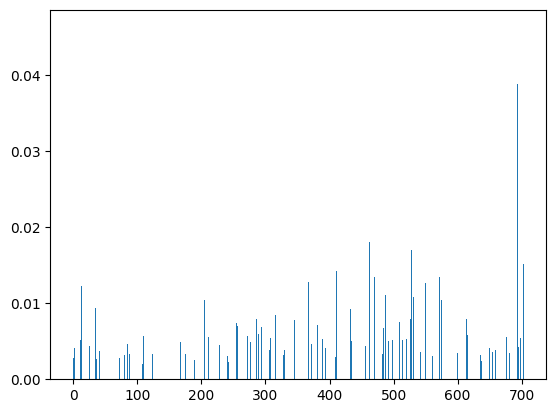

In [22]:
import matplotlib.pyplot as plt

# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

In [12]:
#print(model.get_params())
best_score

[116.85649177958001,
 139.59680280029895,
 148.85358970418517,
 152.59329048866346,
 158.99656183962122,
 162.71394217175663,
 164.8392869694121,
 164.48594726229385]

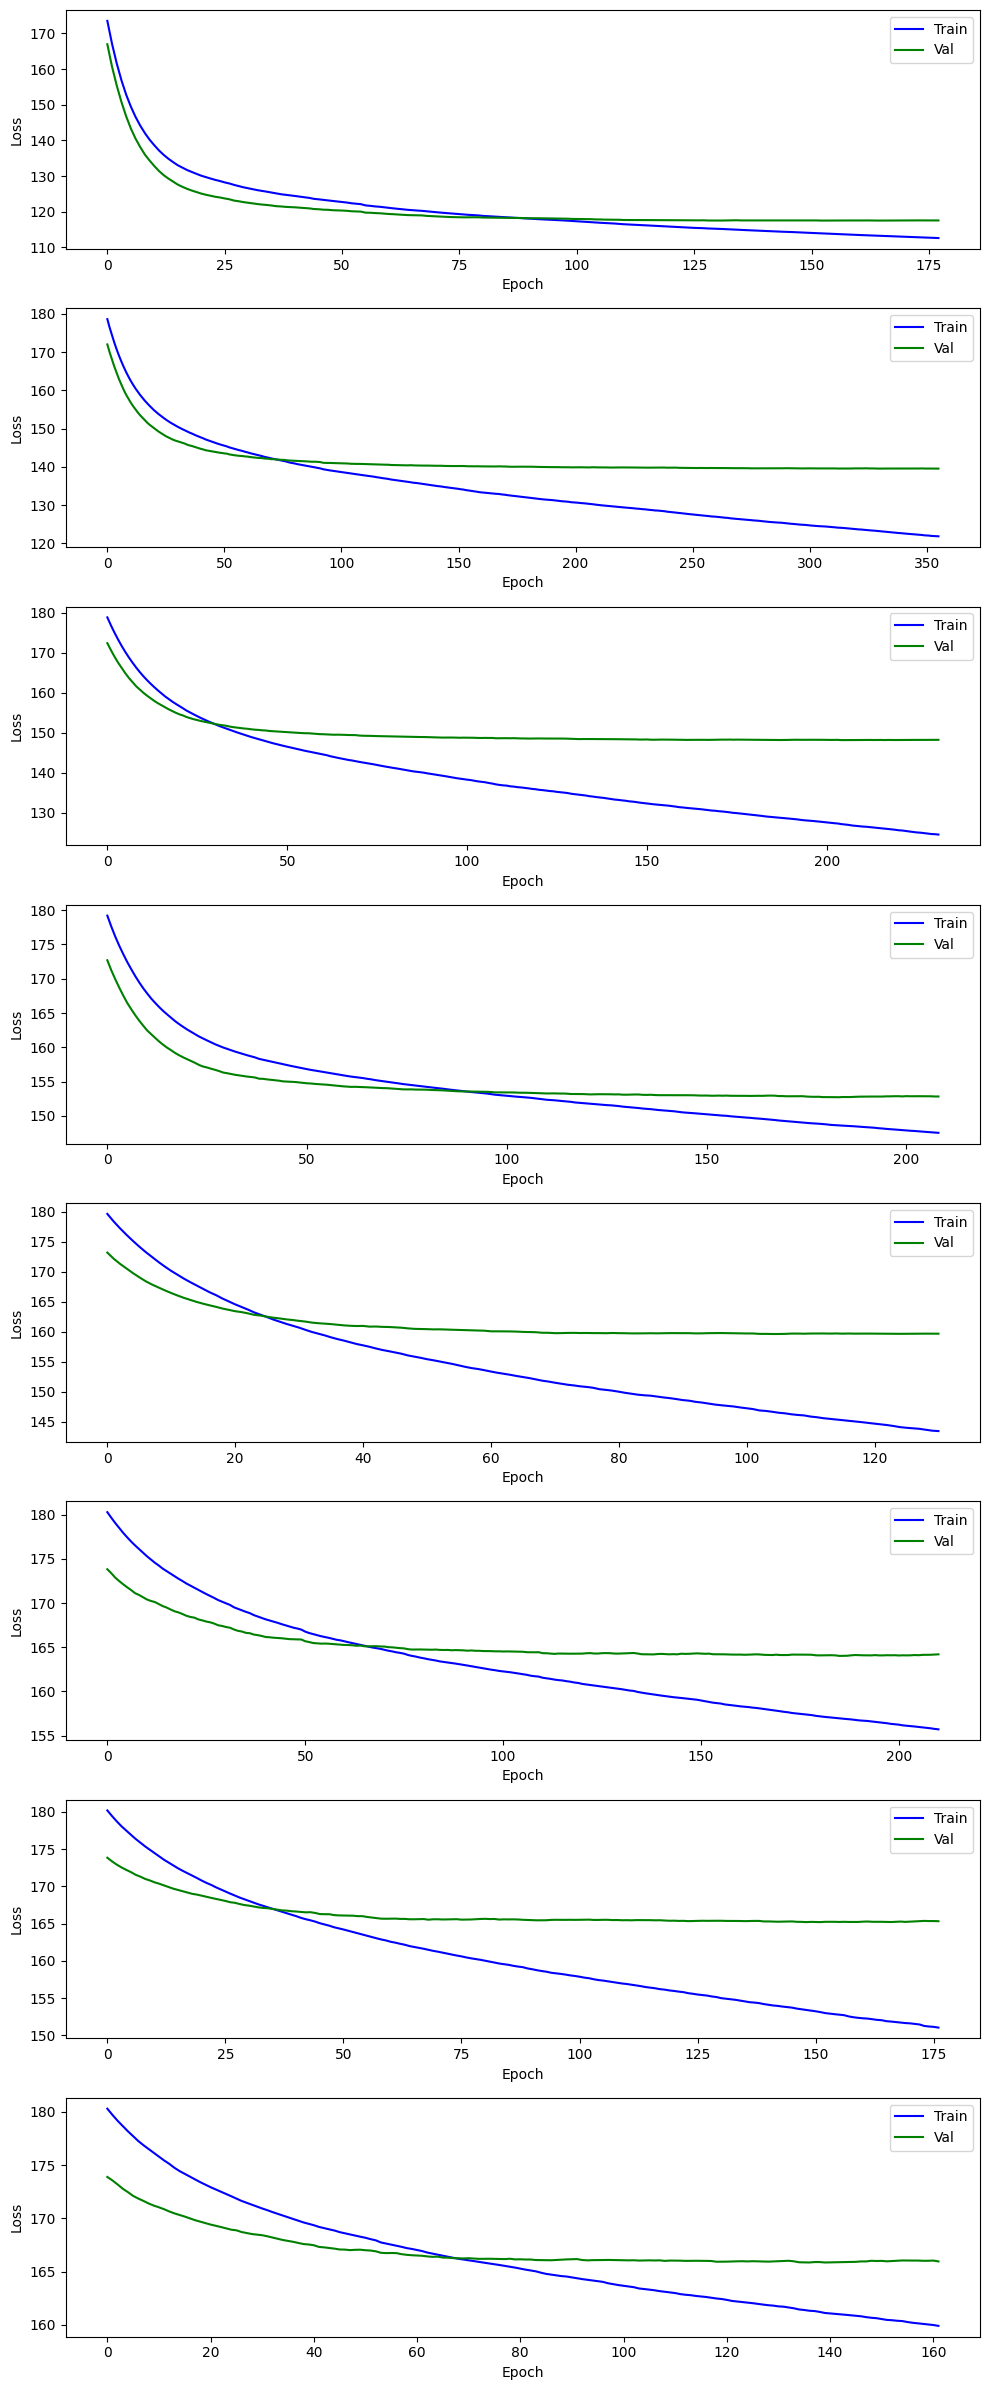

In [10]:
inference_helpers.arrange_figures_in_rows(n_rows=num_models1, prefix="final_nfl_2_")

In [ ]:
# pozorovani
# -- xgboost vyuziva vsechny stromy k predikci, dohormady davaji nejlepsi
# prediktor az do k-te vrstvy
# -- posledni z eval_metrics se pouziva k early_stopping, takze je treba je usporadat
# -- validacni sada bude potreba k treninku, tudiz musim sehnat i testovaci sadu
# ? mozna bych mohl dostahovat aktualni data